In [1281]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from collections import Counter
from nltk.util import bigrams, trigrams

blue_gray_cmap = LinearSegmentedColormap.from_list(
    "blue_gray",
    ["#2d4ca3", "#8e8e8e"]   
)

In [1282]:
# Utilities
def load_text(path):
    chunks = []
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        for line in f:
            chunks.append(line.lower())
    return "".join(chunks)

# Load text
text = load_text("data/text.txt")

In [1283]:
df_stopwords = pd.read_csv("stop_words.csv")
CUSTOM_STOPWORDS = set(df_stopwords["word"].str.lower())
PROTECTED_PHRASES = pd.read_csv("protected_phrases.csv")

In [1284]:
ALLOWED_POS = ("NN", "NNS", "NNP", "NNPS", "JJ", "JJR", "JJS")

In [1285]:
ACRONYMS = {"pinn", "dnn", "cnn", "gpu", "fwi", "rnn", "fno","gan","fdm","mlp"}

In [1286]:
PHRASE_STOPWORDS = {
    "acoustic acoustic",
    "neural network",
    "finite element",
    "boundary condition"
}


In [1287]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))
stop_words.update(CUSTOM_STOPWORDS)

In [1288]:
def remove_consecutive_duplicates(tokens):
    return [t for i, t in enumerate(tokens) if i == 0 or t != tokens[i-1]]

In [1289]:
# --------------------------------------------------
# TEXT CLEANING
# --------------------------------------------------

text_ = text.lower()

# remove numbers
text_ = re.sub(r"\d+", " ", text_)


# keep hyphens to avoid splitting scientific terms
text_ = re.sub(r"[^\w\s-]", " ", text_)

# normalize hyphens
text_ = re.sub(r"-+", " ", text_)


text_ = re.sub(r"\b(\w+)\s+\1\b", r"\1", text_)

# tokenize
tokens = word_tokenize(text_)

# --------------------------------------------------
# PROTECT MULTI-WORD EXPRESSIONS (BI + TRI GRAMS)
# --------------------------------------------------

token_bigrams = list(bigrams(tokens))
token_trigrams = list(trigrams(tokens))

protected = {
    " ".join(ngram)
    for ngram in token_bigrams + token_trigrams
    if " ".join(ngram) in PROTECTED_PHRASES
}

# --------------------------------------------------
# POS TAGGING + FILTERING
# --------------------------------------------------

pos_tags = nltk.pos_tag(tokens)

filtered_tokens = []

for word, pos in pos_tags:

    if pos not in ALLOWED_POS:
        continue

    if not word.isalpha():
        continue

    lemma = lemmatizer.lemmatize(word.lower())

    # remove short tokens
    if len(lemma) <= 2:
        continue

    # skip stopwords
    if lemma in stop_words:
        continue


    # avoid duplicates for acronyms
    if lemma in ACRONYMS:
        if lemma not in filtered_tokens:
            filtered_tokens.append(lemma)
        continue

    filtered_tokens.append(lemma)

# --------------------------------------------------
# ADD PROTECTED PHRASES BACK
# --------------------------------------------------

filtered_tokens.extend(
    phrase.replace(" ", "_") for phrase in protected
)

filtered_tokens = remove_consecutive_duplicates(filtered_tokens)

# --------------------------------------------------
# RESULTS
# --------------------------------------------------

word_counts = Counter(filtered_tokens)
clean_text = " ".join(filtered_tokens)

# save cleaned text
with open("data/clean_text.txt", "w", encoding="utf-8") as f:
    f.write(clean_text)

In [1290]:
len(tokens)

332505

In [1291]:
len(filtered_tokens)

31210

In [1292]:
print(clean_text)

jun decoder reverse rodolfo freitasa carlos barbosaa gabriel guerrab alvaro coutinhoa rochinhaa coppe federal rio janeiro brazil mechanical federal fluminense brazil info reverse positioning highresolution localization intensive monte carlo fold dimensionality decoder experimentation salient industry horizon conjunction specialized optical illuminating arrangement email rodolfosmfreitas com rodolfo mecanica coppe ufrj rochinha orcid barbosa coutinho rochinha decoder reverse situation complicated excitation physicsbased query quantified monte carlo plausible approximate prone propagated outer loop sequential probabilistic plausible probabilistic tomography stochastic hence migrated reverse reflector industry post horizon resulting quantified propagate carlo post horizon probabilistic replacing uncertain ver decoder reverse locity demand efficiency query consolidated cheap considerable moderate dimensionality multifidelity traction unique scalable approximators highlighting substantial p

In [1293]:
WORD_GROUPS = {
    "PINN": ["pinn", "physics informed neural network", "physics-informed neural network"],
    "DNN": ["dnn", "deep neural network", "deep neural networks"],
    "FEM": ["fem", "finite element method", "finite elements"],
    "BEM": ["bem", "boundary element method"],
    "CNN": ["cnn", "convolutional neural network"],
    "acoustic": ["acoustic", "acoustics"],
}

GROUP_LOOKUP = {}

for canonical, variants in WORD_GROUPS.items():
    for v in variants:
        GROUP_LOOKUP[v] = canonical

In [1294]:
grouped_tokens = []

for token in filtered_tokens:
    token_lower = token.lower()

    if token_lower in GROUP_LOOKUP:
        grouped_tokens.append(GROUP_LOOKUP[token_lower])
    else:
        grouped_tokens.append(token)

In [1295]:
clean_text = " ".join(grouped_tokens)

 

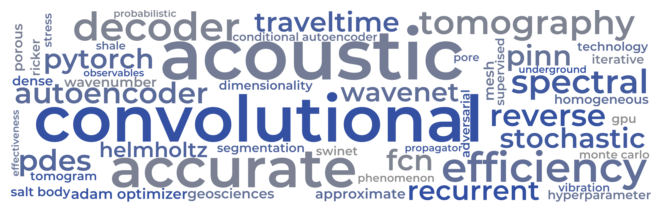

In [1299]:
wc = WordCloud(
    font_path="Montserrat-SemiBold.ttf",
    background_color="white",
    colormap=blue_gray_cmap,
    prefer_horizontal=0.7,
    max_words=50,
    width=4100,
    height=int(4100*0.3),
    random_state=4,
    min_font_size=1,
    max_font_size=450
)

wc.generate(clean_text)

plt.figure(figsize=(6.5, (6.8*0.3)), constrained_layout=True)
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.savefig("figs/wordcloud.svg", dpi=300)
plt.show()
 

In [1297]:
wc.words_

{'acoustic': 1.0,
 'convolutional': 0.8146853146853147,
 'accurate': 0.5804195804195804,
 'efficiency': 0.2972027972027972,
 'decoder': 0.2692307692307692,
 'tomography': 0.26223776223776224,
 'spectral': 0.25874125874125875,
 'reverse': 0.2202797202797203,
 'pdes': 0.1993006993006993,
 'autoencoder': 0.1993006993006993,
 'fcn': 0.19230769230769232,
 'pinn': 0.18181818181818182,
 'stochastic': 0.17832167832167833,
 'pytorch': 0.17832167832167833,
 'traveltime': 0.17482517482517482,
 'recurrent': 0.17482517482517482,
 'wavenet': 0.16783216783216784,
 'helmholtz': 0.14685314685314685,
 'adam optimizer': 0.14685314685314685,
 'mesh': 0.13986013986013987,
 'approximate': 0.13286713286713286,
 'geosciences': 0.13286713286713286,
 'wavenumber': 0.13286713286713286,
 'porous': 0.12937062937062938,
 'dense': 0.12237762237762238,
 'homogeneous': 0.11888111888111888,
 'salt body': 0.11888111888111888,
 'ricker': 0.11538461538461539,
 'dimensionality': 0.11188811188811189,
 'iterative': 0.1118881

In [1298]:
import pandas as pd

df = pd.DataFrame(
    wc.words_.keys(),
    columns=["word"]
)

df.to_csv("wordcloud_words.csv", index=False)